**Pricing strategy to maximize revenue based on demand, competitor pricing, and discounts.**

In [21]:
# library Imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # For high-level interface
import plotly.graph_objects as go # For more control
from bokeh.plotting import figure, show
import altair as alt
import pygal
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

1. Loading and Exploring the Data

In [22]:
df = pd.read_csv('data/retail_store_inventory.csv')

In [23]:
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

2. Feature Engineering

In [25]:
# Effective price after discount
df["Effective Price"] = df["Price"] * (1 - df["Discount"] / 100)

# Revenue = Effective price × Units Sold
df["Revenue"] = df["Effective Price"] * df["Units Sold"]

# Encoding categorical variables
df = pd.get_dummies(df, columns=["Category", "Region", "Weather Condition", "Seasonality"], drop_first=True)


3. Model to Predict Optimal Price

In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd

# Prepare data
X = df.drop(columns=["Date", "Store ID", "Product ID", "Revenue", "Units Sold", "Price"])
y = df["Revenue"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Get feature importances
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display
importance_df


,Feature,Importance
2,Demand Forecast,0.624456
6,Effective Price,0.242965
5,Competitor Pricing,0.117216
0,Inventory Level,0.010703
3,Discount,0.001895
4,Holiday/Promotion,0.000220
15,Weather Condition_Snowy,0.000220
1,Units Ordered,0.000211
19,Seasonality_Winter,0.000206
18,Seasonality_Summer,0.000201


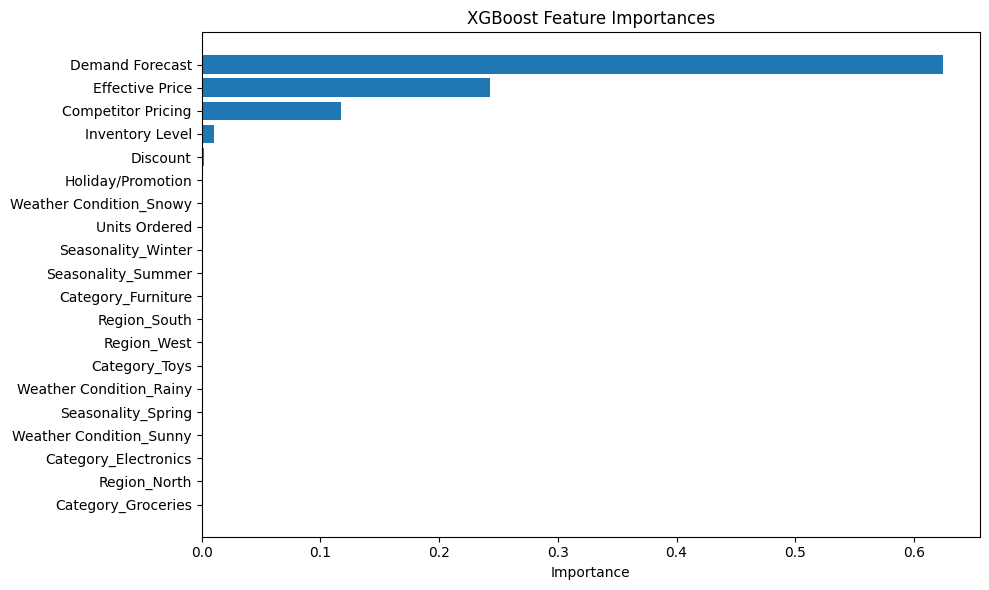

In [27]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()